# **Lab 5: Machine Learning Algorithms**

Name: Madhavi Chitnis

PRN: 20220802070

# **K Means Clustering**



---



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pima.csv to pima.csv


### **Step: 1 Import necessary libraries**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Step: 2 Initialize Spark Session**

In [ ]:
#Creating a Spark Session
spark = SparkSession.builder \
.appName("KMeans Clustering") \
.getOrCreate()

### **Step: 3 Load Dataset**

In [ ]:
# Load the CSV file into a DataFrame
df = spark.read.csv("pima.csv", header=True, inferSchema=True)


### **Step: 4 Data Preprocessing**

In [ ]:
df.printSchema()

root
 |-- preg: integer (nullable = true)
 |-- plas: integer (nullable = true)
 |-- pres: integer (nullable = true)
 |-- skin: integer (nullable = true)
 |-- test: integer (nullable = true)
 |-- mass: double (nullable = true)
 |-- pedi: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)



In [ ]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              preg|             plas|              pres|              skin|              test|              mass|              pedi|               age|             class|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|               768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.952217567727642|115.244002351338

### **Handle Missing Values (if any) (Replacing 0s with median)**

In [ ]:
columns_to_fix = ["plas", "pres", "skin", "test", "mass"]
for col_name in columns_to_fix:
    median_value = df.approxQuantile(col_name, [0.5], 0.0)[0]  # Compute median
    #df = df.withColumn(col_name, col(col_name).cast("double"))  # Ensure column is double type
    df = df.withColumn(col_name, when(col(col_name) == 0, median_value).otherwise(col(col_name)))  # Replace 0s with median

### **Step: 5 Convert Features into Sparse Vectors**

In [ ]:
feature_cols = [col for col in df.columns if col != "class"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = vector_assembler.transform(df).select("features")

### **Step: 6 Apply K-Means Clustering**

In [ ]:
k = 3  # You can modify the number of clusters
kmeans = KMeans(featuresCol="features", k=k, seed=42)
model = kmeans.fit(df)
predictions = model.transform(df)

### **Step: 7 Evaluate the Clustering model**

In [ ]:
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)

### **Step: 8 Calculate WCSS (Within-Cluster Sum of Squares)**

In [ ]:
wcss = model.summary.trainingCost

### **Display Results**

In [ ]:
print(f"Number of Clusters: {k}")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")

Number of Clusters: 3
Silhouette Score: 0.7435
Within-Cluster Sum of Squares (WCSS): 2271012.7590


### **Display Cluster Centers**

In [ ]:
print("\nCluster Centers:")
for idx, center in enumerate(model.clusterCenters()):
    print(f"Cluster {idx + 1}: {center}")


Cluster Centers:
Cluster 1: [  3.85740741 114.97777778  72.51481481  25.86111111  41.48888889
  31.6062963    0.43577037  33.24259259]
Cluster 2: [  3.91428571 157.57142857  71.25714286  32.28571429 453.
  34.86571429   0.56665714  34.28571429]
Cluster 3: [  3.79792746 133.82901554  72.23316062  30.55958549 175.50777202
  34.3761658    0.55570984  33.04663212]


### **Step 9: For Visualizations**

1. Add predictions back to the original DataFrame (with the actual columns, not just features).

2. Reduce dimensions to 2 using PCA for visualization.

3. Convert the result to Pandas.

4. Plot clusters using Seaborn or Matplotlib.

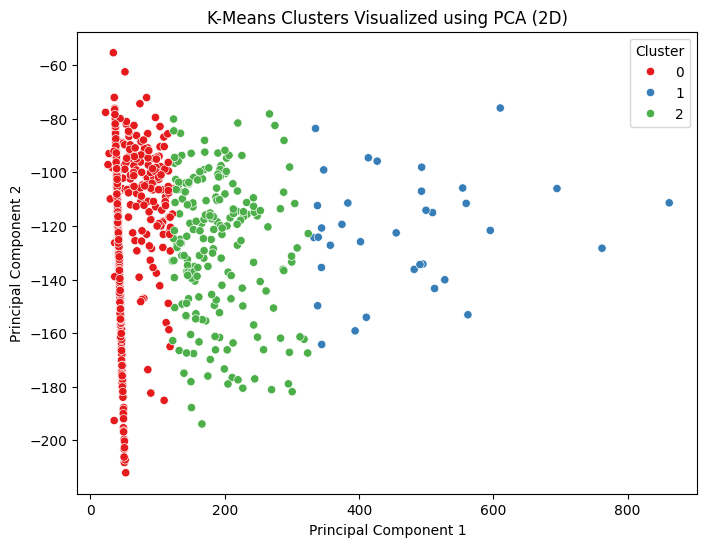

In [ ]:
# Step 1: Load original data with predictions
original_df = spark.read.csv("pima.csv", header=True, inferSchema=True)

# Replace 0s with median again for consistency
for col_name in columns_to_fix:
    median_value = original_df.approxQuantile(col_name, [0.5], 0.0)[0]
    original_df = original_df.withColumn(col_name, when(col(col_name) == 0, median_value).otherwise(col(col_name)))

# Assemble features again
original_df = VectorAssembler(inputCols=feature_cols, outputCol="features").transform(original_df)

# Add predictions
final_df = model.transform(original_df)

# Step 2: Apply PCA to reduce features to 2D
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(final_df)
pca_result = pca_model.transform(final_df)

# Step 3: Convert to Pandas for plotting
plot_df = pca_result.select("pca_features", "prediction").toPandas()

# Split PCA vector into 2D columns
plot_df[['x', 'y']] = plot_df['pca_features'].apply(lambda x: pd.Series([x[0], x[1]]))

# Step 4: Plot clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x='x', y='y', hue='prediction', palette='Set1')
plt.title("K-Means Clusters Visualized using PCA (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


In [ ]:
print("Features used for clustering:", feature_cols)


Features used for clustering: ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']


### **Stop Spark Session**

In [ ]:
spark.stop()